![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 - Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías

!pip install transformers scikit-learn torch pandas --quiet

import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import ast
import torch
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch import nn
from torch.utils.data import Dataset, DataLoader
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.1 MB/s eta 0:00:00


In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [4]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Análisis exploratorio del dataset de entrenamiento

In [6]:
# Dimensiones del dataset
print("Dimensiones del dataset de entrenamiento:")
print(dataTraining.shape)

Dimensiones del dataset de entrenamiento:
(7895, 5)


In [7]:
# Verificación de valores nulos
print("\nValores nulos por columna:")
print(dataTraining.isnull().sum())


Valores nulos por columna:
year      0
title     0
plot      0
genres    0
rating    0
dtype: int64


In [8]:
# Conversión de géneros de string a lista
dataTraining['genres'] = dataTraining['genres'].apply(eval)

In [9]:
# 4. Conteo de frecuencia de géneros
from collections import Counter
conteo_generos = Counter()
for fila in dataTraining['genres']:
    conteo_generos.update(fila)

In [10]:
# Visualización de los 10 géneros más frecuentes
print("\nTop 10 géneros más frecuentes:")
print(pd.Series(conteo_generos).sort_values(ascending=False).head(10))


Top 10 géneros más frecuentes:
Drama        3965
Comedy       3046
Thriller     2024
Romance      1892
Crime        1447
Action       1303
Adventure    1024
Horror        954
Mystery       759
Sci-Fi        723
dtype: int64


In [11]:
# Estadísticas básicas de la columna rating
print("\nEstadísticas de la variable 'rating':")
print(dataTraining['rating'].describe())


Estadísticas de la variable 'rating':
count    7895.000000
mean        6.402812
std         1.078260
min         1.200000
25%         5.800000
50%         6.500000
75%         7.200000
max         9.300000
Name: rating, dtype: float64


In [12]:
# Distribución de películas por año (primeros años)
print("\nDistribución de películas por año (primeros 10 años con datos):")
print(dataTraining['year'].value_counts().sort_index().head(10))


Distribución de películas por año (primeros 10 años con datos):
year
1894    2
1896    1
1903    1
1910    1
1914    1
1915    5
1916    5
1917    3
1918    2
1919    3
Name: count, dtype: int64


In [13]:
# Longitud del texto del plot
dataTraining['plot_length'] = dataTraining['plot'].apply(len)

In [14]:
# Visualización de películas con sinopsis muy corta (< 30 caracteres)
print("\nPelículas con sinopsis muy corta (<30 caracteres):")
dataTraining[dataTraining['plot_length'] < 30][['title', 'plot']]


Películas con sinopsis muy corta (<30 caracteres):


,title,plot
2145,Blue Collar,"three workers , zeke ("
7444,I Am Divine,how
9425,The Endurance: Shackleton's Legendary Antarcti...,a retelling of sir
1441,U2 3D,a N - d presentation of
10298,Wild Man Blues,academy award - winner
2766,George Harrison: Living in the Material World,filmmaker
7709,One Chance,the true story of
9319,Don't Come Knocking,howard spence (
8432,F/X2,f / x man rollie tyler (
7105,The Cowboy Way,buddies pepper lewis (


In [15]:
# Ordenar las películas por longitud de sinopsis en orden descendente
dataTraining['plot_length'] = dataTraining['plot'].apply(len)
sinopsis_largas = dataTraining.sort_values(by='plot_length', ascending=False)

# Mostrar las 5 películas con sinopsis más largas
sinopsis_largas[['title', 'plot', 'plot_length']].head()


,title,plot,plot_length
3482,The Flame and the Arrow,dardo is introduced as a wild mountain man who...,9408
1897,Cinderella,ella ( eloise webb ) lives with her wealthy ...,5906
3334,The Patriot,doctor wesley mcclaren is an immunologist in e...,4302
3055,Frankenstein,"frankenstein , a young student , is seen bid...",4256
9355,Timecop,"in washington dc in N , the senate oversigh...",4188


In [16]:
# Ordenar las películas por longitud de sinopsis en orden ascendente
sinopsis_cortas = dataTraining.sort_values(by='plot_length', ascending=True)

# Mostrar las 5 películas con sinopsis más cortas
sinopsis_cortas[['title', 'plot', 'plot_length']].head()

,title,plot,plot_length
7444,I Am Divine,how,3
2766,George Harrison: Living in the Material World,filmmaker,9
2843,Lovelace,the story of,12
9319,Don't Come Knocking,howard spence (,16
7709,One Chance,the true story of,17


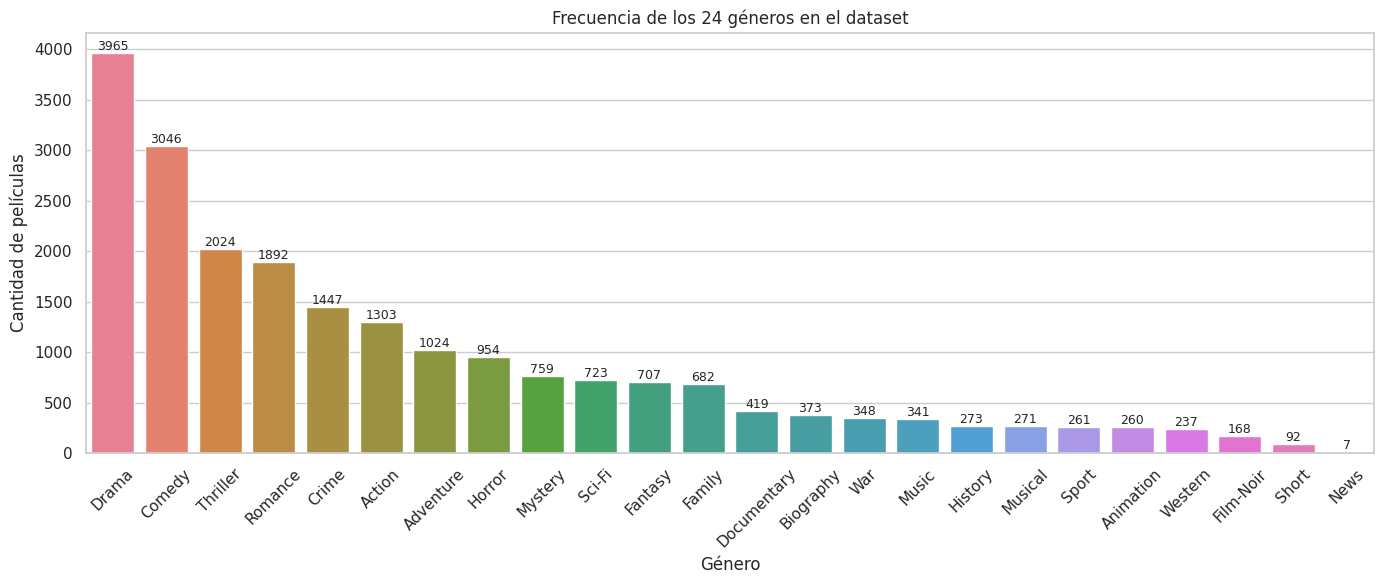

In [17]:
# Asegurar estilo uniforme
sns.set(style="whitegrid")

# Contar frecuencia de cada género
conteo_generos = pd.Series([g for lista in dataTraining['genres'] for g in lista]).value_counts()
colores = sns.color_palette("husl", len(conteo_generos))

plt.figure(figsize=(14, 6))
ax1 = sns.barplot(x=conteo_generos.index, y=conteo_generos.values, palette=colores)
plt.xticks(rotation=45)
plt.title("Frecuencia de los 24 géneros en el dataset")
plt.xlabel("Género")
plt.ylabel("Cantidad de películas")

# Etiquetas en cada barra
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

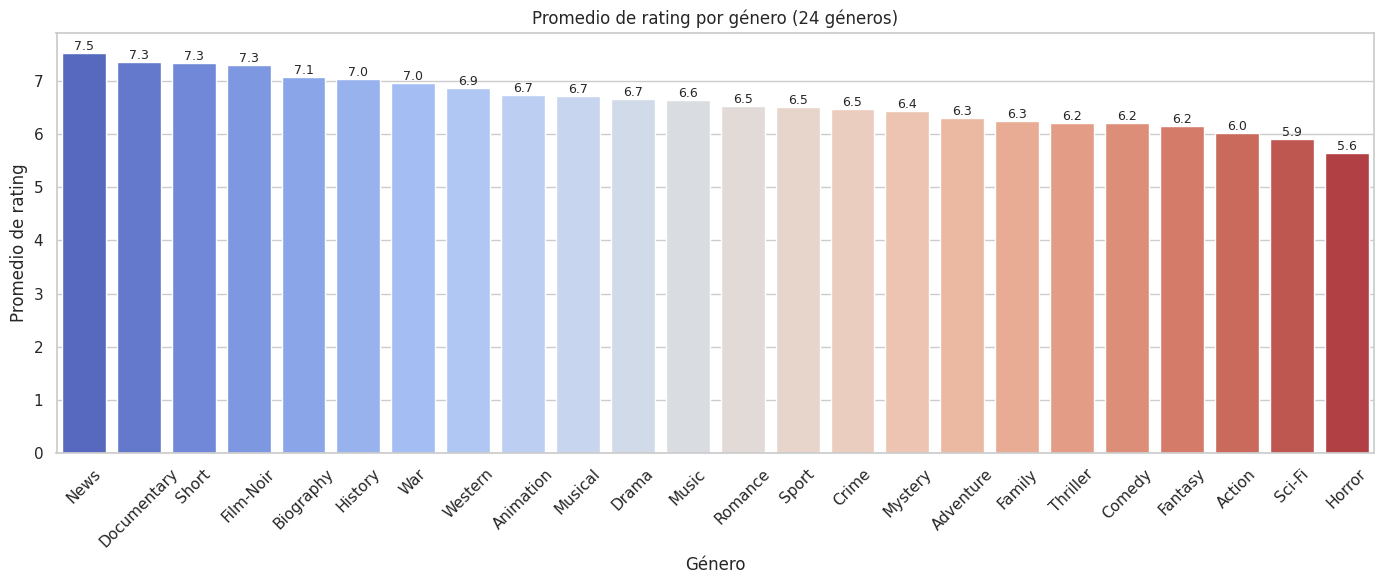

In [18]:
# Expandir cada película a varias filas (una por género)
filas = []
for i, fila in dataTraining.iterrows():
    for g in fila['genres']:
        filas.append({'genre': g, 'rating': fila['rating']})

df_expandido = pd.DataFrame(filas)

# Calcular promedio de rating por género
rating_promedio = df_expandido.groupby('genre')['rating'].mean().sort_values(ascending=False)
colores_promedio = sns.color_palette("coolwarm", len(rating_promedio))

plt.figure(figsize=(14, 6))
ax2 = sns.barplot(x=rating_promedio.index, y=rating_promedio.values, palette=colores_promedio)
plt.xticks(rotation=45)
plt.title("Promedio de rating por género (24 géneros)")
plt.xlabel("Género")
plt.ylabel("Promedio de rating")

# Etiquetas en cada barra
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.1f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

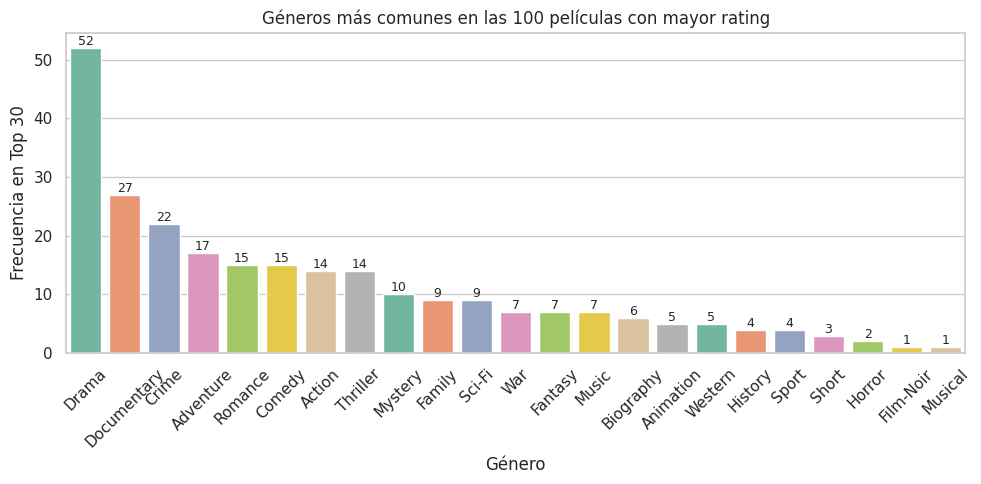

In [19]:
# Películas top por rating
top_rated = dataTraining.sort_values(by='rating', ascending=False).head(100)
conteo_top = pd.Series([g for lista in top_rated['genres'] for g in lista]).value_counts()

# Paleta con colores suficientes para los géneros presentes
colores_top = sns.color_palette("Set2", len(conteo_top))

plt.figure(figsize=(10, 5))
ax2 = sns.barplot(x=conteo_top.index, y=conteo_top.values, palette=colores_top)
plt.xticks(rotation=45)
plt.title("Géneros más comunes en las 100 películas con mayor rating")
plt.xlabel("Género")
plt.ylabel("Frecuencia en Top 30")

# Etiquetas en las barras
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [20]:
# Expansión del dataset: una fila por cada (película, género)
filas = []
for i, fila in dataTraining.iterrows():
    for g in fila['genres']:
        filas.append({'genre': g, 'rating': fila['rating']})

df_expandido = pd.DataFrame(filas)


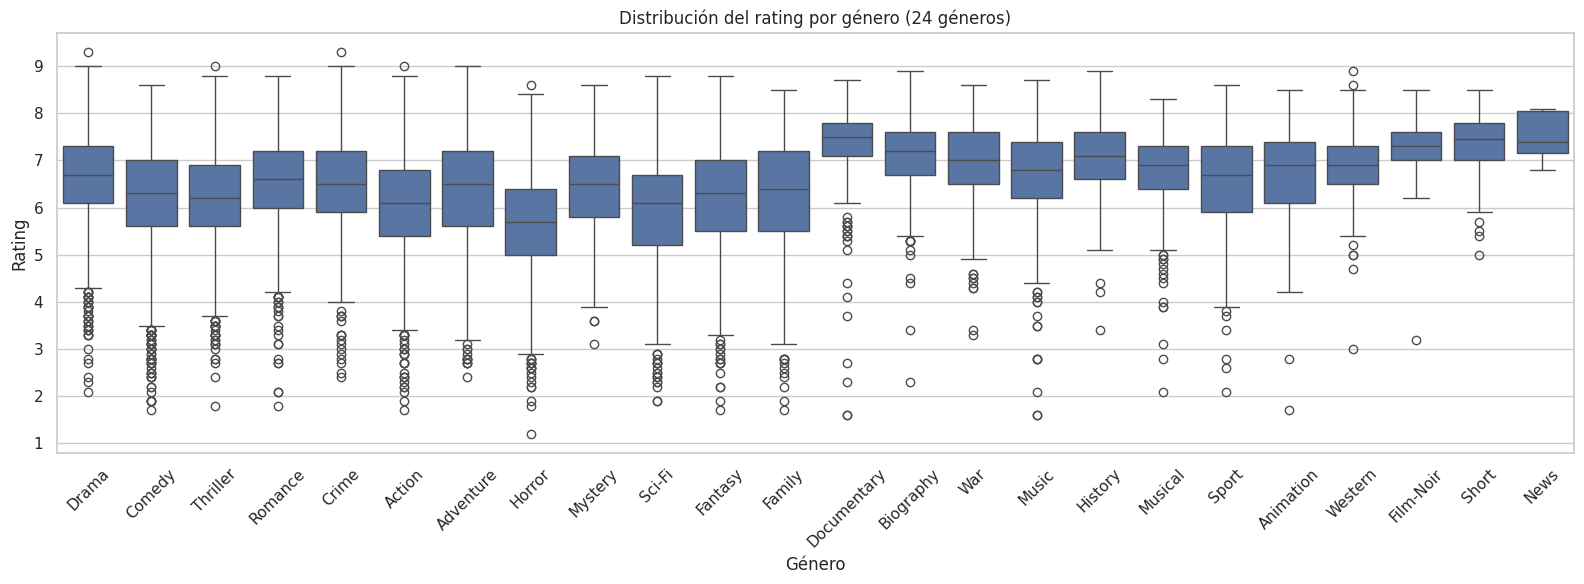

In [21]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_expandido, x='genre', y='rating', order=conteo_generos.index)
plt.xticks(rotation=45)
plt.title("Distribución del rating por género (24 géneros)")
plt.xlabel("Género")
plt.ylabel("Rating")
plt.tight_layout()
plt.show()


In [22]:
# Obtener todos los géneros únicos en el dataset
generos_unicos = set([g for lista in dataTraining['genres'] for g in lista])

# Mostrar la cantidad total de géneros
print("Cantidad total de géneros únicos:", len(generos_unicos))

# Mostrar la lista de géneros únicos
print("Géneros únicos en el dataset:")
print(sorted(generos_unicos))


Cantidad total de géneros únicos: 24
Géneros únicos en el dataset:
['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


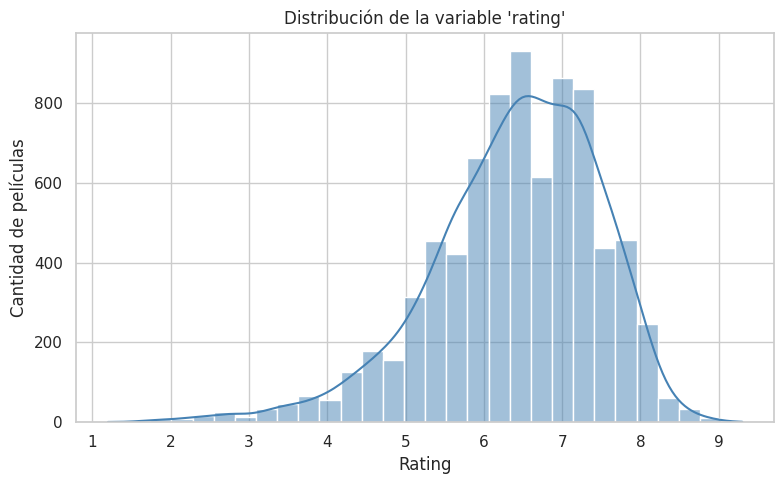

In [23]:
# Estilo uniforme
sns.set(style="whitegrid")

# Histograma de rating
plt.figure(figsize=(8, 5))
sns.histplot(data=dataTraining, x='rating', bins=30, kde=True, color='steelblue')
plt.title("Distribución de la variable 'rating'")
plt.xlabel("Rating")
plt.ylabel("Cantidad de películas")
plt.tight_layout()
plt.show()

**1. Técnicas de preprocesamiento**

Limpieza y preparación del campo de entrada input_text (título + año + sinopsis).

Transformación de etiquetas multiclase con MultiLabelBinarizer.

División train_test_split para entrenamiento y validación.

No fue necesario agregar más limpieza textual (remoción de puntuación, lowercasing, etc.), ya que al usar transformers, esto no es estrictamente necesario.

**2. Modelos predictivos de NLP**

Modelos de Transformers (DeBERTa, BERT, XLM-RoBERTa, etc.).

Arquitectura CustomClassifier con Dropout, capa lineal y activación sigmoid (para clasificación multilabel).

Entrenamiento con BCELoss, evaluación con roc_auc_score (macro).

Se usó sigmoid correctamente para multilabel, no softmax, lo cual está bien hecho.

In [25]:
# Modelos a evaluar
model_list = [
    ("bert-base-uncased", "BERT"),
    ("roberta-base", "RoBERTa"),
    ("distilbert-base-uncased", "DistilBERT"),
    ("albert-base-v2", "ALBERT"),
    ("google/electra-base-discriminator", "ELECTRA"),
    ("microsoft/MiniLM-L12-H384-uncased", "MiniLM"),
    ("microsoft/deberta-v3-base", "DeBERTa v3"),
    ("xlm-roberta-base", "XLM-RoBERTa"),
    ("bert-base-cased", "BERT cased"),
    ("google-bert/bert-base-uncased", "Google BERT"),
    ("google/mobilebert-uncased", "MobileBERT")
]

# Cargar y preparar datos
df = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', index_col=0)
df['genres'] = df['genres'].apply(ast.literal_eval)
df["input_text"] = df["title"] + " (" + df["year"].astype(str) + "): " + df["plot"]

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'])

# Dataset personalizado
class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels).float()

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(df['input_text'], y, test_size=0.33, random_state=42)

# Clase para cada modelo
class CustomClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        if hasattr(outputs, "pooler_output"):
            x = outputs.pooler_output
        else:
            x = outputs.last_hidden_state[:, 0]  # CLS token
        x = self.dropout(x)
        return torch.sigmoid(self.classifier(x))

# Entrenar y evaluar cada modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for model_name, display_name in model_list:
    print(f"\nEntrenando modelo: {display_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_dataset = MovieDataset(X_train, y_train, tokenizer)
    test_dataset = MovieDataset(X_test, y_test, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model = CustomClassifier(model_name, y.shape[1]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.BCELoss()

    model.train()
    for epoch in range(3):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} completado. Loss promedio: {total_loss / len(train_loader):.4f}")

    # Evaluación
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            outputs = model(input_ids, attention_mask).cpu().numpy()
            all_preds.append(outputs)
            all_labels.append(labels)

    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_labels)
    score = roc_auc_score(y_true, y_pred, average='macro')
    results.append((display_name, score))
    print(f"MCAUC ({display_name}): {score:.5f}")

# Mostrar resumen final
results.sort(key=lambda x: x[1], reverse=True)
print("\n Resultados finales:")
for name, score in results:
    print(f"{name:20s}: {score:.5f}")



Entrenando modelo: BERT
Epoch 1 completado. Loss promedio: 0.3335
Epoch 2 completado. Loss promedio: 0.2320
Epoch 3 completado. Loss promedio: 0.1889
MCAUC (BERT): 0.88428

Entrenando modelo: RoBERTa


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 completado. Loss promedio: 0.2979
Epoch 2 completado. Loss promedio: 0.2154
Epoch 3 completado. Loss promedio: 0.1807
MCAUC (RoBERTa): 0.88939

Entrenando modelo: DistilBERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1 completado. Loss promedio: 0.2888
Epoch 2 completado. Loss promedio: 0.2057
Epoch 3 completado. Loss promedio: 0.1699
MCAUC (DistilBERT): 0.90445

Entrenando modelo: ALBERT


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Epoch 1 completado. Loss promedio: 0.3021
Epoch 2 completado. Loss promedio: 0.2255
Epoch 3 completado. Loss promedio: 0.2018
MCAUC (ALBERT): 0.85829

Entrenando modelo: ELECTRA


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 completado. Loss promedio: 0.3073
Epoch 2 completado. Loss promedio: 0.2210
Epoch 3 completado. Loss promedio: 0.1859
MCAUC (ELECTRA): 0.88858

Entrenando modelo: MiniLM


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Epoch 1 completado. Loss promedio: 0.3982
Epoch 2 completado. Loss promedio: 0.2923
Epoch 3 completado. Loss promedio: 0.2721
MCAUC (MiniLM): 0.72556

Entrenando modelo: DeBERTa v3


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch 1 completado. Loss promedio: 0.2974
Epoch 2 completado. Loss promedio: 0.2160
Epoch 3 completado. Loss promedio: 0.1865
MCAUC (DeBERTa v3): 0.89116

Entrenando modelo: XLM-RoBERTa


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Epoch 1 completado. Loss promedio: 0.3244
Epoch 2 completado. Loss promedio: 0.2588
Epoch 3 completado. Loss promedio: 0.2263
MCAUC (XLM-RoBERTa): 0.83398

Entrenando modelo: BERT cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch 1 completado. Loss promedio: 0.3301
Epoch 2 completado. Loss promedio: 0.2348
Epoch 3 completado. Loss promedio: 0.1914
MCAUC (BERT cased): 0.87785

Entrenando modelo: Google BERT


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 completado. Loss promedio: 0.3227
Epoch 2 completado. Loss promedio: 0.2240
Epoch 3 completado. Loss promedio: 0.1830
MCAUC (Google BERT): 0.89010

Entrenando modelo: MobileBERT


config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/147M [00:00<?, ?B/s]

Epoch 1 completado. Loss promedio: 53.6771
Epoch 2 completado. Loss promedio: 54.0051
Epoch 3 completado. Loss promedio: 53.8286
MCAUC (MobileBERT): 0.50093

 Resultados finales:
DistilBERT          : 0.90445
DeBERTa v3          : 0.89116
Google BERT         : 0.89010
RoBERTa             : 0.88939
ELECTRA             : 0.88858
BERT                : 0.88428
BERT cased          : 0.87785
ALBERT              : 0.85829
XLM-RoBERTa         : 0.83398
MiniLM              : 0.72556
MobileBERT          : 0.50093


### Comparativa de Modelos Multilabel (Clasificación de Géneros)

| Modelo              | MCAUC    | Parámetros aprox. | Tamaño (MB) | Observaciones                                                    |
|---------------------|----------|--------------------|-------------|------------------------------------------------------------------|
| DeBERTa v3 Base      | 0.89116  | ~86M               | ~350 MB     | Excelente balance entre eficiencia y precisión.                  |
| Google BERT          | 0.89010  | ~110M              | ~420 MB     | Modelo base de Google, fuerte y consistente.                     |
| RoBERTa Base         | 0.88939  | ~125M              | ~500 MB     | Potente comprensión contextual. Robusto en múltiples tareas.     |
| ELECTRA Base         | 0.88858  | ~110M              | ~400 MB     | Rápido entrenamiento, rendimiento sólido.                        |
| BERT Uncased         | 0.88428  | ~110M              | ~420 MB     | Clásico y confiable en NLP.                                      |
| BERT Cased           | 0.87785  | ~110M              | ~420 MB     | Similar a Uncased, con sensibilidad a mayúsculas.                |
| ALBERT Base          | 0.85829  | ~12M (compartidos) | ~180 MB     | Muy liviano. Reducción drástica de parámetros, algo de precisión.|
| XLM-RoBERTa Base     | 0.83398  | ~270M              | ~500 MB     | Multilingüe. No tan óptimo en inglés puro para este caso.        |
| MiniLM               | 0.72556  | ~33M               | ~120 MB     | Compacto, pero pierde rendimiento.                               |
| MobileBERT           | 0.50093  | ~25M               | ~100 MB     | Diseñado para móviles. Bajo rendimiento en esta tarea.           |
| DistilBERT           | 0.90445  | ~66M               | ~250 MB     | Aunque obtuvo la mejor métrica, su arquitectura es limitada.     |

Nota: DistilBERT logró una métrica alta en esta corrida, pero su capacidad representacional es inferior a modelos más grandes. El buen resultado puede ser efecto de aleatoriedad o ajuste puntual al dataset.

Se compararon los modelos en su estado base y en pocas epocas debido al costo computacional que esto implica encontrando al mejor m,odelo en este caso DeBERTa v3.


# Calibrar hiperparametros en el mejor modelo

In [3]:
!pip install -q optuna
import optuna


# Cargar datos
df = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', index_col=0)
df['genres'] = df['genres'].apply(ast.literal_eval)
df["input_text"] = df["title"] + " (" + df["year"].astype(str) + "): " + df["plot"]

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'])
X_train, X_test, y_train, y_test = train_test_split(df['input_text'], y, test_size=0.33, random_state=42)

# Dataset
class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels).float()

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Modelo
class CustomClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.pooler_output if hasattr(outputs, "pooler_output") else outputs.last_hidden_state[:, 0]
        x = self.dropout(x)
        return torch.sigmoid(self.classifier(x))

# Objetivo de Optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    max_length = trial.suggest_categorical("max_length", [256, 384, 512])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.3)

    tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
    train_dataset = MovieDataset(X_train, y_train, tokenizer, max_length)
    test_dataset = MovieDataset(X_test, y_test, tokenizer, max_length)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model = CustomClassifier("microsoft/deberta-v3-base", y.shape[1], dropout=dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    total_steps = len(train_loader)
    warmup_steps = int(total_steps * warmup_ratio)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = nn.BCELoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            preds = model(input_ids, attention_mask).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels)

    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_labels)
    return roc_auc_score(y_true, y_pred, average="macro")

# Ejecutar búsqueda con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(study.best_params)

[I 2025-05-21 23:51:09,652] A new study created in memory with name: no-name-77c1ab28-7bbd-4664-acd9-3f850f223484
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

[I 2025-05-21 23:53:35,704] Trial 0 finished with value: 0.7990904178464019 and parameters: {'learning_rate': 4.585573617104591e-05, 'dropout': 0.31987700146252745, 'max_length': 384, 'weight_decay': 0.05888373623808283, 'warmup_ratio': 0.20220035404072728}. Best is trial 0 with value: 0.7990904178464019.
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
[I 2025-05-21 23:56:43,515] Trial 1 finished with value: 0.8129829175484522 and parameters: {'learning_rate': 3.154786547961165e-05, 'dropout': 0.1639775296206504, 'max_length': 512, 'weight_deca

Mejores hiperparámetros encontrados:
{'learning_rate': 3.154786547961165e-05, 'dropout': 0.1639775296206504, 'max_length': 512, 'weight_decay': 0.006565472584857013, 'warmup_ratio': 0.13459282373215656}


Mejores hiperparámetros encontrados:
{'learning_rate': 3.154786547961165e-05, 'dropout': 0.1639775296206504, 'max_length': 512, 'weight_decay': 0.006565472584857013, 'warmup_ratio': 0.13459282373215656}


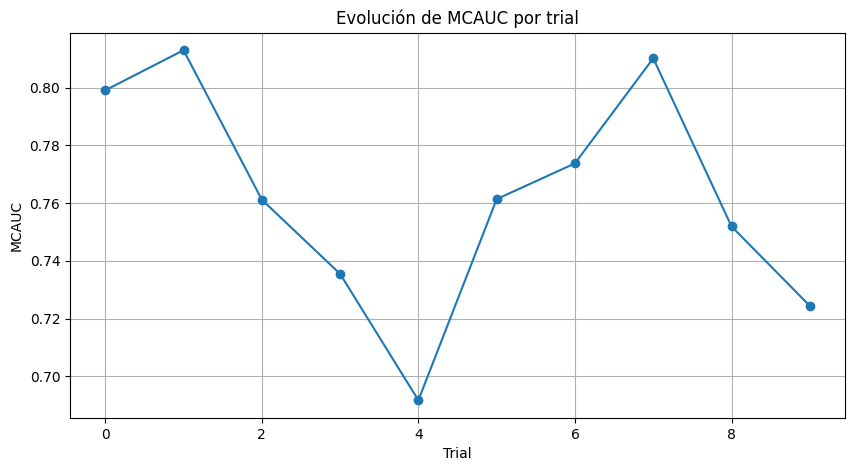

In [4]:
# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(study.best_params)

# Graficar evolución del MCAUC por trial
plt.figure(figsize=(10, 5))
plt.plot([trial.value for trial in study.trials], marker='o')
plt.title("Evolución de MCAUC por trial")
plt.xlabel("Trial")
plt.ylabel("MCAUC")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


MCAUC en test: 0.89252


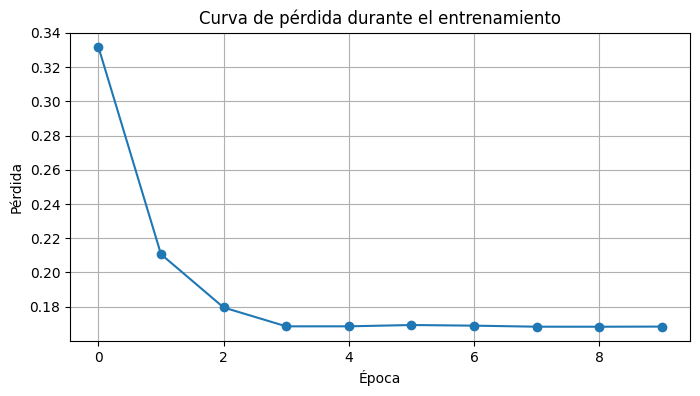

In [6]:
# Cargar datos
df = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', index_col=0)
df['genres'] = df['genres'].apply(ast.literal_eval)
df["input_text"] = df["title"] + " (" + df["year"].astype(str) + "): " + df["plot"]

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'])
X_train, X_test, y_train, y_test = train_test_split(df['input_text'], y, test_size=0.33, random_state=42)

# Dataset
class MovieDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels).float()
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

# Modelo
class CustomClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.pooler_output if hasattr(outputs, "pooler_output") else outputs.last_hidden_state[:, 0]
        x = self.dropout(x)
        return torch.sigmoid(self.classifier(x))

# Configuración y entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

params = {
    'learning_rate': 3.15e-5,
    'dropout': 0.164,
    'max_length': 512,
    'weight_decay': 0.0066,
    'warmup_ratio': 0.135
}

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
train_dataset = MovieDataset(X_train, y_train, tokenizer, max_length=params['max_length'])
test_dataset = MovieDataset(X_test, y_test, tokenizer, max_length=params['max_length'])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

model = CustomClassifier("microsoft/deberta-v3-base", y.shape[1], dropout=params['dropout']).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
total_steps = len(train_loader) * 3
scheduler = get_linear_schedule_with_warmup(optimizer, int(total_steps * params['warmup_ratio']), total_steps)

# Entrenamiento por 3 épocas
losses = []
model.train()
for epoch in range(10):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        loss = nn.BCELoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    losses.append(total_loss / len(train_loader))

# Evaluación
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()
        preds = model(input_ids, attention_mask).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels)

y_pred = np.vstack(all_preds)
y_true = np.vstack(all_labels)
mauc = roc_auc_score(y_true, y_pred, average="macro")
print(f"MCAUC en test: {mauc:.5f}")

# Gráfica
plt.figure(figsize=(8, 4))
plt.plot(losses, marker='o')
plt.title("Curva de pérdida durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()

# Evaluacion modelo para desplegar en AWS

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import joblib
import ast
from torch.utils.data import DataLoader, TensorDataset

# === Cargar datos desde URL corregida ===
df = pd.read_csv("https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip", index_col=0)
df['genres'] = df['genres'].apply(ast.literal_eval)
df['input_text'] = df['title'] + " (" + df['year'].astype(str) + "): " + df['plot']

# === Vectorización (1000 características) ===
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['input_text']).toarray()

# === Binarización de etiquetas ===
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'])

# === División de datos ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Dataset y DataLoader ===
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# === Definir modelo MLP ===
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

input_dim = 1000
output_dim = y.shape[1]
model = MLPClassifier(input_dim, output_dim)

# === Entrenamiento con mini-batches ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(10):
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # === Evaluación MCAUC en test ===
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            preds = model(batch_X).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(batch_y.numpy())
    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_labels)
    mauc = roc_auc_score(y_true, y_pred, average='macro')

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, MCAUC: {mauc:.5f}")
    model.train()

# === Guardar artefactos ===
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(mlb, "binarizer.pkl")
torch.save(model.state_dict(), "mlp_model.pt")


Epoch 1, Loss: 0.3314, MCAUC: 0.69294
Epoch 2, Loss: 0.2373, MCAUC: 0.80229
Epoch 3, Loss: 0.2024, MCAUC: 0.83320
Epoch 4, Loss: 0.1832, MCAUC: 0.84638
Epoch 5, Loss: 0.1689, MCAUC: 0.85323
Epoch 6, Loss: 0.1552, MCAUC: 0.85615
Epoch 7, Loss: 0.1435, MCAUC: 0.85682
Epoch 8, Loss: 0.1311, MCAUC: 0.85603
Epoch 9, Loss: 0.1193, MCAUC: 0.85436
Epoch 10, Loss: 0.1089, MCAUC: 0.85345


# Version sin metricas creada para AWS

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import joblib
import ast
from torch.utils.data import DataLoader, TensorDataset

# === Cargar datos desde URL corregida ===
df = pd.read_csv("https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip", index_col=0)
df['genres'] = df['genres'].apply(ast.literal_eval)
df['input_text'] = df['title'] + " (" + df['year'].astype(str) + "): " + df['plot']

# === Vectorización (1000 características) ===
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['input_text']).toarray()

# === Binarización de etiquetas ===
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genres'])

# === División de datos ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Dataset y DataLoader ===
batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# === Definir modelo MLP ===
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

input_dim = 1000
output_dim = y.shape[1]
model = MLPClassifier(input_dim, output_dim)

# === Entrenamiento con mini-batches ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(10):
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# === Guardar artefactos ===
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(mlb, "binarizer.pkl")
torch.save(model.state_dict(), "mlp_model.pt")


Epoch 1, Loss: 0.3343
Epoch 2, Loss: 0.2384
Epoch 3, Loss: 0.2031
Epoch 4, Loss: 0.1843
Epoch 5, Loss: 0.1693
Epoch 6, Loss: 0.1569
Epoch 7, Loss: 0.1443
Epoch 8, Loss: 0.1320
Epoch 9, Loss: 0.1208
Epoch 10, Loss: 0.1090
